In [19]:
import os
import warnings

import matplotlib
import tqdm
from tqdm.notebook import tqdm
from tqdm.contrib.telegram import tqdm
import torch
from transformers import  RobertaTokenizer, RobertaModel

# Use Tokenizer to calculate token size statistics

In [ ]:
tqdm.pandas()
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
os.environ['TOKENIZERS_PARALLELISM'] = 'false'




In [ ]:
import pickle
with open('/home/jovyan/sentences.pkl', 'rb') as f:
    sentences = pickle.load(f)   

In [17]:
len(sentences)

27309035

In [6]:
model_name = 'sberbank-ai/ruRoberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name, do_lower_case=False)  

In [34]:
class DescriptionDataset(Dataset):
    def __init__(self, tokenizer, descs, max_len=256):
        self.descs = descs
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        
    def __getitem__(self, idx):
        
        desc_cls = '[CLS]' + self.descs[idx]       
        tokenized_desc_cls = self.get_tokens(desc_cls, max_len=64)
        cat_ids = tokenized_desc_cls['input_ids']
        cat_atts = tokenized_desc_cls['attention_mask']                
        
        labels = cat_ids.detach().clone()
        
        tokenized_descs = {
            "input_ids": self.get_masked(cat_ids),
            "attention_mask": cat_atts,
            "labels": labels
        }
        
        return tokenized_descs

    def __len__(self):
        return len(self.descs)
    
    def get_tokens(self, row, max_len=128, pad_str='max_length'):
        tokenized = self.tokenizer.encode_plus(
            row, add_special_tokens=False, truncation=True,
             padding=pad_str, 
            return_tensors='pt', return_token_type_ids=False
        )
        return tokenized
    
    def get_masked(self, input_ids):
        # create random array of floats with equal dimensions to input_ids tensor
        rand = torch.rand(input_ids.shape)
        # create mask array
        mask_arr = (rand < 0.15) * (input_ids != 101) * \
                   (input_ids != 102) * (input_ids != 0)
        
        input_ids[mask_arr] = 103
            
        return input_ids

In [40]:
train_data = DescriptionDataset(
    tokenizer,
    sentences
)
iterator = DataLoader(train_data, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
list_len = []
for i, batch in enumerate(iterator):
    list_len.append(len(batch['input_ids'][0][0]))

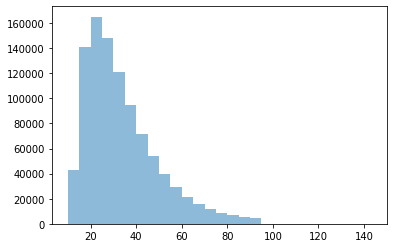

In [43]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.array(list_len)

# fixed bin size
bins = np.arange(-100, 100, 5) # fixed bin size

plt.xlim([min(data)-5, 150])

plt.hist(data, bins=bins, alpha=0.5)

plt.show()

In [7]:
%%time
def len_tkns(ss):
    ret = [tokenizer.encode_plus(x, add_special_tokens=False, truncation=True,             
            return_tensors='pt', return_token_type_ids=False) for x in ss]
#     ret = [len(x) for x in ret]
    return ret
    

with Pool(16) as pl:
    output_lens = pl.map(len_tkns, sentences[:2]) 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 73.8 ms, sys: 2.19 s, total: 2.27 s
Wall time: 4.05 s
